# Tweaking the Model

In this colab, you'll investigate how various tweaks to data processing and the model itself can impact results. At the end, you'll once again be able to visualize how the network sees the related sentiment of each word in the dataset.

## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Get the dataset

We'll once again use the dataset containing Amazon and Yelp reviews. This dataset was originally extracted from [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2024-08-03 12:39:35--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 64.233.170.100, 64.233.170.113, 64.233.170.102, ...
Connecting to drive.google.com (drive.google.com)|64.233.170.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2024-08-03 12:39:36--  https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.175.132, 2404:6800:4003:c1c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.175.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127831 (125K) [application/octet-stream]
Saving to: ‘/tmp/sentiment.csv’

/tmp/sentiment.csv  100%[===================>] 124.83K  --.-KB/s    in 0.02s   

2024-08-03 12:39:38 (6.86 

In [3]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Tokenize the dataset (with tweaks!)

Now, we'll tokenize the dataset, but we can make some changes to this from before. Previously, we used:
```
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
```

How might changing the `vocab_size`, `embedding_dim` or `max_length` affect how the model performs?

In [4]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Train a Sentiment Model (with tweaks!)

We'll use a slightly different model here, using `GlobalAveragePooling1D` instead of `Flatten()`.

In [5]:
model = tf.keras.Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # GlobalAveragePooling1D layer
    tf.keras.layers.GlobalAveragePooling1D(),

    # Dense layer with dropout
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Batch Normalization
    tf.keras.layers.BatchNormalization(),

    # Additional Dense layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
num_epochs = 30
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5205 - loss: 0.7002 - val_accuracy: 0.4110 - val_loss: 0.6983
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5236 - loss: 0.6940 - val_accuracy: 0.4110 - val_loss: 0.6989
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5269 - loss: 0.6918 - val_accuracy: 0.4110 - val_loss: 0.6977
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5345 - loss: 0.6843 - val_accuracy: 0.4110 - val_loss: 0.6965
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6213 - loss: 0.6574 - val_accuracy: 0.4837 - val_loss: 0.6874
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7037 - loss: 0.5868 - val_accuracy: 0.5163 - val_loss: 0.6706
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7809 - loss: 0.4940 - val_accuracy: 0.5238 - val_loss: 0.6635
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7888 - loss: 0.4572 - val_accuracy: 0.6742 - val_loss

## Visualize the training graph

You can use the code below to visualize the training and validation accuracy while you try out different tweaks to the hyperparameters and model.

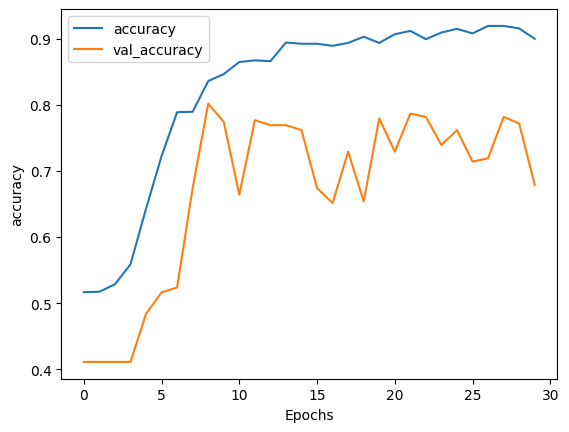

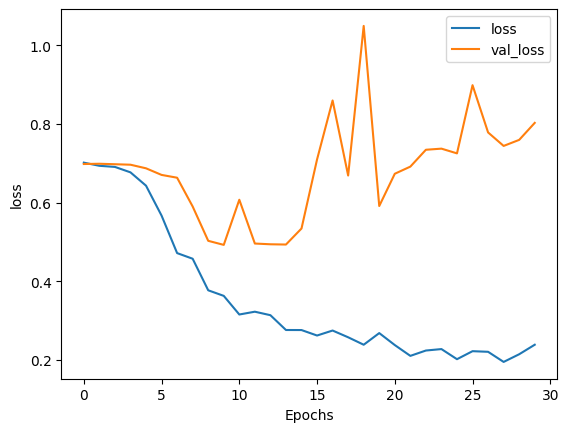

In [7]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Get files for visualizing the network

The code below will download two files for visualizing how your network "sees" the sentiment related to each word. Head to http://projector.tensorflow.org/ and load these files, then click the checkbox to "sphereize" the data.

Note: You may run into errors with the projection if your `vocab_size` earlier was larger than the actual number of words in the vocabulary, in which case you'll need to decrease this variable and re-train in order to visualize.

In [8]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(500, 16)


In [9]:
import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [10]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Predicting Sentiment in New Reviews

Below, we've again included some example new reviews you can test your results on.

In [11]:
# Use the model to predict a review
fake_reviews = [
    'I love this phone',
    'I hate spaghetti',
    'Everything was cold',
    'Everything was hot exactly as I wanted',
    'Everything was green',
    'The host seated us immediately',
    'They gave us free chocolate cake',
    'Not sure about the wilted flowers on the table',
    'Only works when I stand on tippy toes',
    'Does not work when I stand on my head',
    'The service was incredibly slow',
    'The view from the room was breathtaking',
    'The coffee was too bitter for my taste',
    'The restaurant had a cozy atmosphere',
    'The movie was too long and boring',
    'The staff were friendly and helpful',
    'The dessert was too sweet and rich',
    'The room was clean but a bit cramped',
    'The Wi-Fi connection was unreliable',
    'The gym facilities were excellent',
    'The book had an unexpected twist ending',
    'The event was well-organized and enjoyable',
    'The jacket was comfortable but a bit tight',
    'The price was too high for the quality',
    'The app crashed frequently during use',
    'The concert was amazing and lively',
    'The directions were confusing and unclear',
    'The packaging was eco-friendly and attractive',
    'The product arrived ahead of schedule',
    'The noise level was higher than expected'
]

print(fake_reviews)

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'The host seated us immediately', 'They gave us free chocolate cake', 'Not sure about the wilted flowers on the table', 'Only works when I stand on tippy toes', 'Does not work when I stand on my head', 'The service was incredibly slow', 'The view from the room was breathtaking', 'The coffee was too bitter for my taste', 'The restaurant had a cozy atmosphere', 'The movie was too long and boring', 'The staff were friendly and helpful', 'The dessert was too sweet and rich', 'The room was clean but a bit cramped', 'The Wi-Fi connection was unreliable', 'The gym facilities were excellent', 'The book had an unexpected twist ending', 'The event was well-organized and enjoyable', 'The jacket was comfortable but a bit tight', 'The price was too high for the quality', 'The app crashed frequently during use', 'The concert was amazing and lively', 'The directions were 